In [2]:
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
sns.set_style("whitegrid")

In [27]:
path = '../Data/dff1.csv'

In [28]:
df= pd.read_csv(path, parse_dates=['ds'])
# df = df.rename(columns = {"Date":"ds","Close":"y"}) 
df = df[['ds', 'y','fbsp', 'diff','tby', 'ffr', 'fta', 'eps', 'div', 'une', 'wti', 'ppi',
       'rfs']]
# df

In [29]:
df['fbsp_tby'] = df['fbsp'] * df['tby']
df['fbsp_ffr'] = df['fbsp'] * df['ffr']
df['fbsp_div'] = df['fbsp'] * df['div']
df['eps_tby'] = df['eps'] * df['tby']
df['eps_ffr'] = df['eps'] * df['ffr']
df['eps_div'] = df['eps'] * df['div']

In [30]:
cutoff = len(df) - 252
df_train = df[:cutoff].copy()
df_test = df[cutoff:].copy()
print(cutoff)

2300


In [31]:
df_train.columns

Index(['ds', 'y', 'fbsp', 'diff', 'tby', 'ffr', 'fta', 'eps', 'div', 'une',
       'wti', 'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby',
       'eps_ffr', 'eps_div'],
      dtype='object')

In [32]:
possible_features = ['tby', 'ffr', 'fta', 'eps', 'div', 'une', 'wti',
       'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby',
       'eps_ffr', 'eps_div']

from itertools import chain, combinations

def powerset(iterable):
    #"powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

#print(list(powerset(possible_features)))

In [33]:
len(possible_features)

15

In [11]:
from statsmodels.regression.linear_model import OLS

reg_new = OLS((df_train['diff']).copy(),df_train[possible_features].copy()).fit()
print(reg_new.params)

#from the output, we can see it's consistent with sklearn output

tby         305.980303
ffr         183.608289
fta           0.000065
eps          -1.775823
div        -142.530009
une         -80.692625
wti           3.378638
ppi          -7.923858
rfs           0.006087
fbsp_tby     -0.043153
fbsp_ffr     -0.146870
fbsp_div     -0.391168
eps_tby      -2.122760
eps_ffr       2.390346
eps_div       3.950103
dtype: float64


In [12]:
new_coef = reg_new.params
new_possible_feats = new_coef[abs(new_coef)>0].index

power_feats = list(powerset(new_possible_feats))
power_feats.remove(())

power_feats = [ list(feats) for feats in power_feats]
len(power_feats)


32767

In [13]:
AIC_scores = []
parameters = []

for feats in power_feats:
    tmp_reg = OLS((df_train['diff']).copy(),df_train[feats].copy()).fit()
    AIC_scores.append(tmp_reg.aic)
    parameters.append(tmp_reg.params)

    
Min_AIC_index = AIC_scores.index(min(AIC_scores))
Min_AIC_feats = power_feats[Min_AIC_index]  
Min_AIC_params  = parameters[Min_AIC_index]
print(Min_AIC_feats)
print(Min_AIC_params)  

['tby', 'ffr', 'fta', 'div', 'une', 'wti', 'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby', 'eps_ffr', 'eps_div']
tby         313.791358
ffr         187.937377
fta           0.000057
div         -78.607290
une         -87.125044
wti           3.455364
ppi          -8.104355
rfs           0.005916
fbsp_tby     -0.046476
fbsp_ffr     -0.132070
fbsp_div     -0.388510
eps_tby      -2.157124
eps_ffr       2.033978
eps_div       3.252783
dtype: float64


In [14]:
len(Min_AIC_feats)

14

In [15]:
###After selecting the best features, we report the testing error, and make the plot 
AIC_df_test = df_test[Min_AIC_feats]
AIC_pred_test = AIC_df_test.dot(Min_AIC_params)+df_test.fbsp

AIC_df_train = df_train[Min_AIC_feats]
AIC_pred_train = AIC_df_train.dot(Min_AIC_params)+ df_train.fbsp



In [16]:
from sklearn.metrics import mean_squared_error as MSE

mse_train = MSE(df_train.y, AIC_pred_train) 
mse_test = MSE(df_test.y, AIC_pred_test)


#compare with fbprophet()

fb_mse_train = MSE(df_train.y, df_train.fbsp) 
fb_mse_test = MSE(df_test.y, df_test.fbsp)


print(mse_train,fb_mse_train)

print(mse_test,fb_mse_test)

2543.6188296247346 22303.563608543613
11928.655041711927 15247.912341091072


In [19]:
df_train.ds

0       2009-12-15
1       2009-12-16
2       2009-12-17
3       2009-12-18
4       2009-12-21
           ...    
2295    2019-02-20
2296    2019-02-21
2297    2019-02-22
2298    2019-02-25
2299    2019-02-26
Name: ds, Length: 2300, dtype: object

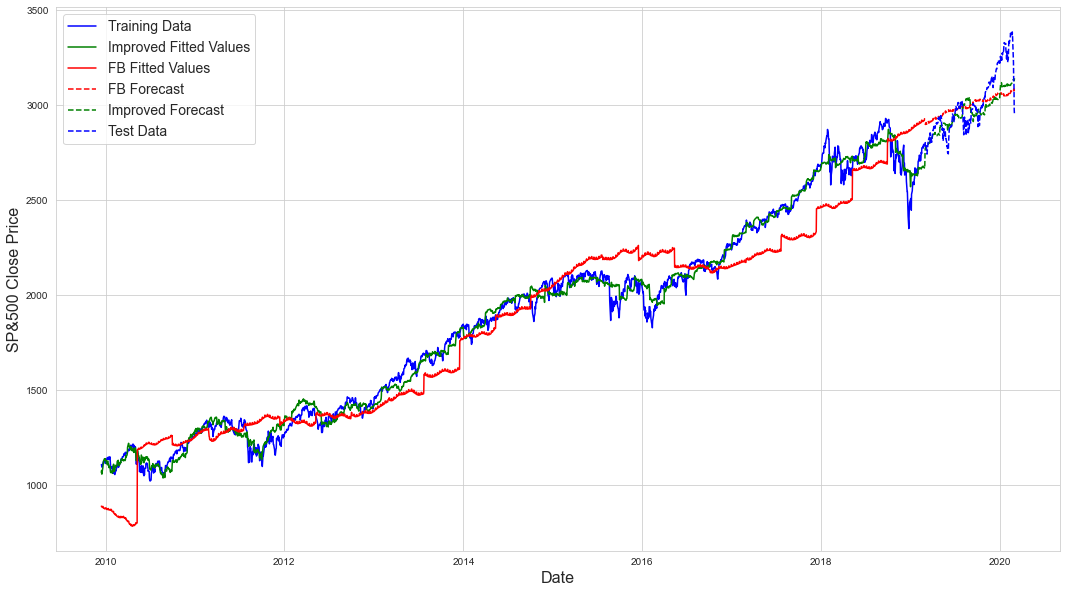

In [34]:
plt.figure(figsize=(18,10))

# plot the training data
plt.plot(df_train.ds,df_train.y,'b',
            label = "Training Data")

plt.plot(df_train.ds, AIC_pred_train,'g-',
            label = "Improved Fitted Values")

# plot the fit
plt.plot(df_train.ds, df_train.fbsp,'r-',
            label = "FB Fitted Values")

# # plot the forecast
plt.plot(df_test.ds, df_test.fbsp,'r--',
            label = "FB Forecast")
plt.plot(df_test.ds, AIC_pred_test,'g--',
            label = "Improved Forecast")
plt.plot(df_test.ds,df_test.y,'b--',
            label = "Test Data")

plt.legend(fontsize=14)

plt.xlabel("Date", fontsize=16)
plt.ylabel("SP&500 Close Price", fontsize=16)

plt.show()